# Import models

In [79]:
import sys
import json
import math
import time
import pickle
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam, LBFGS


from training_data.simdata_mush_dirc import  fdd, pdeinp, icinp, bcinp,HT_sim ,scaler, invscaler
from Model.loss_func import loss_fn_data,pde_loss,ic_loss,boundary_loss
from Model.train_testloop import *


# Get the training data

The spatial step is 0.00020408163265306123
The time step is 0.00014676749271137028


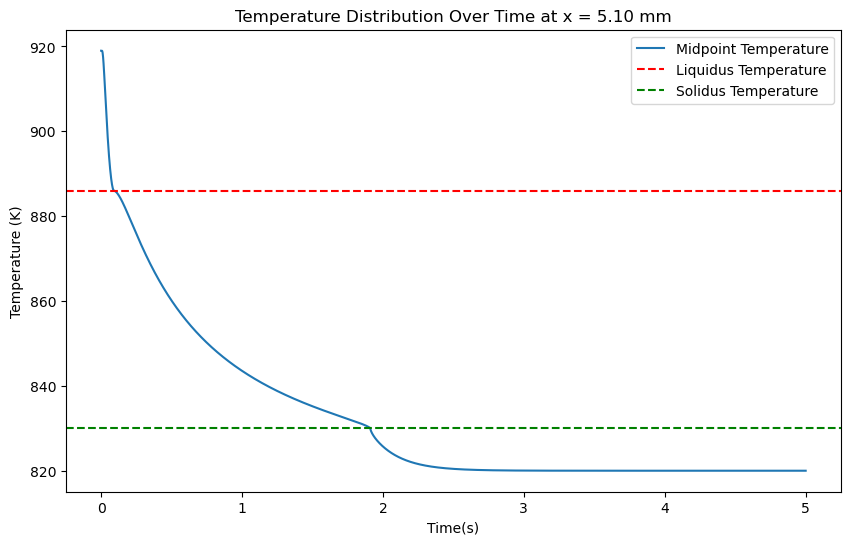

In [80]:
length = 15e-3
time_end = 5.0
numpoints = 50
temp_init = 919.0
t_surr = 500.0

with open('../training_data/settings.json') as file:
    settings = json.load(file)
   


heat_data = HT_sim(settings)
alpha = heat_data.alpha_l
tempfield = heat_data.datagen()

heat_data.plot_temp(25)
dt = heat_data.dt
dx = heat_data.dx
# print(heat_data.dx)
# print(dt)
with open('../training_data/settings.json') as file:
    props = json.load(file)


In [81]:
temp_data = tempfield.flatten()

def temp_scaler(temp_data, temp_init, t_surr):
    temp_data = (temp_data - t_surr) / (temp_init - t_surr)
    return temp_data

# temp_data = scaler(temp_data,400.0,919.0)

temp_data_s = temp_scaler(temp_data, temp_init, t_surr)



In [82]:
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 

pde_pts= 20000
ic_pts = 20000
bc_pts = 20000

x_c = 1/length
t_c = (alpha/(length**2))
temp_c = 919.0

inp_data = fdd(15e-3, time_end, numpoints, num_steps)


# def scale2(x,x_c,t_c):
#     scaled_x = x.copy()
#     scaled_x[:,0] = x[:,0] * x_c
#     scaled_x[:,1] = x[:,1] * t_c
#     return scaled_x

# inp_data2 = scale2(inp_data,x_c,t_c)

# input dataset-pde residual
# The pde inputs are generated using the pdeinp function in simdata.py
pde_data = pdeinp(dx,length-dx,dt,time_end,pde_pts,"Sobol") 

# pde_data2 = scale2(pde_data,x_c,t_c)

# input dataset - ic residual
ic_data = icinp(length,ic_pts,scl="False")
# ic_data2 = scale2(ic_data,x_c,t_c)
# input dataset - boundary residual
bc_ldata = bcinp(length,time_end,bc_pts,dt,scl="False")[0]
bc_rdata = bcinp(length,time_end,bc_pts,dt,scl="False")[1]

# bc_ldata2 = scale2(bc_ldata,x_c,t_c)
# bc_rdata2 = scale2(bc_rdata,x_c,t_c)


scaling initated
The number of points in the PDE input is 20000
The number of points in the initial condition is 20000
scaling not initiated
The number of points in the left boundary condition is 20000
The number of points in the right boundary condition is 20000
scaling not initiated
The number of points in the left boundary condition is 20000
The number of points in the right boundary condition is 20000
scaling not initiated


/opt/anaconda3/envs/pinn/lib/python3.13/site-packages/skopt/sampler/sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+20002=20002. 
  warnings.warn(


# Prepare  the Inputs

In [83]:
if torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

# print('Using device:', device)

# %% [markdown]
# ### Tensor inputs

input_t = torch.tensor(inp_data).float().to(device)
inp_pdet = torch.tensor(pde_data).float().to(device)
inp_ict = torch.tensor(ic_data).float().to(device)
inp_bclt = torch.tensor(bc_ldata).float().to(device)
inp_bclr = torch.tensor(bc_rdata).float().to(device)



temp_t = torch.tensor(temp_data).float().to(device)
temp_t = temp_t.view(-1,1)

# temp_init_s= temp_scaler(919.0, temp_init, t_surr)
# temp_init = scaler(temp_init,500.0,919.0)

temp_init_t = torch.tensor(temp_init).float().to(device)
T_L = props['T_L']                   #  K -Liquidus Temperature (615 c) AL 380
# T_L_s = scaler(T_L,temp_init, t_surr)                     #  K -Liquidus Temperature (615 c) AL 380
# T_L = scaler(T_L,500.0,919.0)
T_S = props['T_S']                   #  K -Solidus Temperature (615 c) AL 380
# T_S_s = scaler(T_S,temp_init, t_surr)                     #  K -Solidus Temperature (615 c) AL 380
# T_S = scaler(T_S,500.0,919.0)                     #  K -Solidus Temperature (615 c) AL 380
# t_surr_s = temp_scaler(t_surr, temp_init, t_surr)
# t_surr = scaler(t_surr,500.0,919.0)
t_surr = props['t_surr']                   #  K -Surrounding Temperature (500 c) AL 380
T_lt = torch.tensor(T_L).float().to(device)    # Liquidus Temperature tensor
T_st = torch.tensor(T_S).float().to(device)    # Solidus Temperature tensor
t_surrt = torch.tensor(t_surr).float().to(device)   # Surrounding Temperature tensor

temp_var = {"T_st":T_st,"T_lt":T_lt,"t_surrt":t_surrt,"temp_init_t":temp_init_t}

# %% [markdown]
# ### Dataset Preparation for pytorch

# %%
train_inputs,test_inputs =train_test_split(input_t,test_size=0.2,random_state=42) # input data split
# print(train_inputs.shape)
tr_inp_pde,ts_inp_pde = train_test_split( inp_pdet,test_size=0.2,random_state=42) # input pde data split
# print(tr_inp_pde.shape)
tr_inp_ic,ts_inp_ic = train_test_split( inp_ict,test_size=0.2,random_state=42) # input ic data split
# print(tr_inp_ic.shape)

tr_inp_bcl,ts_inp_bcl = train_test_split( inp_bclt,test_size=0.2,random_state=42) # input bc left data split
tr_inp_bcr,ts_inp_bcr = train_test_split( inp_bclr,test_size=0.2,random_state=42) # input bc right data split
# nn
# 

train_temp,test_temp = train_test_split(temp_t,test_size=0.2,random_state=42) # output data split



# %%
class Data_Tensor_Dataset(TensorDataset):#dataset class for tsimulation data
    def __init__(self,inputs,outputs,transform=None, target_transform =None):   
        self.inputs = inputs
        self.outputs = outputs

    def __getitem__(self, index):
        return self.inputs[index],self.outputs[index]
    
    def __len__(self):
        return len(self.inputs)

class ResDataset(TensorDataset): #dataset class for pde residuals and bcs,ics
    def __init__(self, inputs,transform=None, target_transform =None):
        self.inputs = inputs
        

    def __getitem__(self, index):
        return self.inputs[index]
    
    def __len__(self):
        return len(self.inputs)

# %% [markdown]
# ### Dataset Preparation

# %%
inp_dataset = Data_Tensor_Dataset(train_inputs,train_temp)
inp_dataset_test = Data_Tensor_Dataset(test_inputs,test_temp)

inp_pde_dataset = ResDataset(tr_inp_pde) # pde residual dataset for training
inp_pde_dataset_test = ResDataset(ts_inp_pde) # pde residual dataset for testing

inp_ic_dataset = ResDataset(tr_inp_ic) # ic residual dataset for training
inp_ic_dataset_test = ResDataset(ts_inp_ic) # ic residual dataset for testing

inp_bcl_dataset = ResDataset(tr_inp_bcl) # bc left residual dataset for training
inp_bcl_dataset_test = ResDataset(ts_inp_bcl) # bc left residual dataset for testing

inp_bcr_dataset = ResDataset(tr_inp_bcr) # bc right residual dataset for training
inp_bcr_dataset_test = ResDataset(ts_inp_bcr)   # bc right residual dataset for testing

# %%
# print(len(inp_ic_dataset))

# %% [markdown]
# ### Dataloader Preparation

# %%
rand_smpl = RandomSampler(inp_dataset, replacement=False,num_samples=10000)  # random sampler for training/simulation data
rand_smpl_pde = RandomSampler(inp_pde_dataset, replacement=False, num_samples=10000) # random sampler for pde residuals-training
rand_smpl_ic = RandomSampler(inp_ic_dataset, replacement=False, num_samples=10000)  # random sampler for ic residuals-training
rand_smpl_bcl = RandomSampler(inp_bcl_dataset, replacement=False, num_samples=10000) # random sampler for bc left residuals-training
rand_smpl_bcr = RandomSampler(inp_bcr_dataset, replacement=False, num_samples=10000) # random sampler for bc right residuals-training

rand_smpl_test = RandomSampler(inp_dataset_test, replacement=False, num_samples=10000 )  # random sampler for testing/simulation data
rand_smpl_pde_test = RandomSampler(inp_pde_dataset_test,replacement=False, num_samples=10000)  # random sampler for pde residuals
rand_smpl_ic_test = RandomSampler(inp_ic_dataset_test,replacement=False, num_samples=10000 )  # random sampler for ic residuals
rand_smpl_bcl_test = RandomSampler(inp_bcl_dataset_test,replacement=False, num_samples=10000) # random sampler for bc left residuals
rand_smpl_bcr_test = RandomSampler(inp_bcr_dataset_test,replacement=False, num_samples=10000) # random sampler for bc right residuals

train_loader = DataLoader(inp_dataset, batch_size=256, sampler=rand_smpl) # training data loader
pde_loader = DataLoader(inp_pde_dataset, batch_size=256, sampler=rand_smpl_pde) # pde residual data loader training
ic_loader = DataLoader(inp_ic_dataset, batch_size=256, sampler=rand_smpl_ic) # ic residual data loader training
bcl_loader = DataLoader(inp_bcl_dataset, batch_size=256, sampler=rand_smpl_bcl) # bc left residual data loader training
bcr_loader = DataLoader(inp_bcr_dataset, batch_size=256, sampler=rand_smpl_bcr) # bc right residual data loader training


test_loader = DataLoader(inp_dataset_test, batch_size=256, sampler=rand_smpl_test) # testing data loader
pde_loader_test = DataLoader(inp_pde_dataset_test, batch_size=256, sampler=rand_smpl_pde_test)
ic_loader_test = DataLoader(inp_ic_dataset_test, batch_size=256, sampler=rand_smpl_ic_test)
bcl_loader_test = DataLoader(inp_bcl_dataset_test, batch_size=256, sampler=rand_smpl_bcl_test)
bcr_loader_test = DataLoader(inp_bcr_dataset_test, batch_size=256, sampler=rand_smpl_bcr_test)



MPS is available


# Prepare the Model

In [84]:
input_size = 2
hidden_size = 30 
output_size=1

learning_rate = 0.009
hidden_layers = 8


epochs_1 = 5
epochs_2 = 10
from Model.model import PINN

model = PINN(input_size, hidden_size, output_size,hidden_layers).to(device)
optimizer_1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_2 = torch.optim.LBFGS(model.parameters(), lr=learning_rate)



# Train the model

In [85]:
torch.autograd.set_detect_anomaly(True)

#train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs_1, model, loss_fn_data, \
                #   optimizer_1,train_loader,pde_loader, ic_loader,\
                #   bcl_loader,bcr_loader,\
                #   test_loader,pde_loader_test,ic_loader_test,\
                #   bcl_loader_test,bcr_loader_test,\
                #   temp_var)  # Train the model 

loss_train,loss_test,best_model = training_loop(epochs_1, model, loss_fn_data, \
                  optimizer_1,train_loader,pde_loader, ic_loader,\
                  bcl_loader,bcr_loader,\
                  test_loader,pde_loader_test,ic_loader_test,\
                  bcl_loader_test,bcr_loader_test,\
                  temp_var)

 
----------------------------------------------------------------------------------------------------
| Epoch 1,            | Training-Loss 3.6504e+07,| Test-Loss 3.5882e+07   |
----------------------------------------------------------------------------------------------------
| Data-loss 6.5456e+05,| pde-loss 2.0677e+00,| initc-loss 8.1756e+05,|bc_loss 8.0197e+04|
----------------------------------------------------------------------------------------------------
| Data-loss-test 1.3183e+06,| pde-loss-test 7.0905e-16,| initc-loss-test 8.1702e+05,|bc_loss-test 8.0028e+04|
----------------------------------------------------------------------------------------------------
 
 
----------------------------------------------------------------------------------------------------
| Epoch 5,            | Training-Loss 3.2269e+07,| Test-Loss 3.1775e+07   |
----------------------------------------------------------------------------------------------------
| Data-loss 5.9415e+05,| pde-loss 1.

# Collect the results and store it an folder/ Visualise the results

In [86]:

def move_to_cpu(obj):
    """Recursively move tensors in a dictionary or list to CPU."""
    if isinstance(obj, torch.Tensor):
        return obj.cpu()
    elif isinstance(obj, list):
        return [move_to_cpu(item) for item in obj]  # Convert tensors inside lists
    elif isinstance(obj, dict):
        return {k: move_to_cpu(v) for k, v in obj.items()}  # Convert tensors inside dicts
    return obj  # Return unchanged for other types

# Ensure all tensors inside lists/dicts are on CPU
loss_train = move_to_cpu(loss_train)
loss_test = move_to_cpu(loss_test)



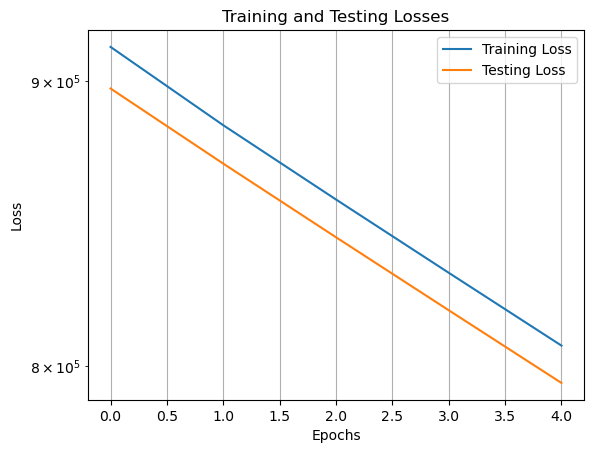

In [87]:
# plot the losses

train_loss = loss_train['train-loss']
test_loss = loss_test['test-loss']
loss_pde = loss_train['pde-loss']
loss_ic = loss_train['ic-loss']
loss_bcl = loss_train['bc-loss']


plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()